## 1. Обзор данных
В этой части рассматривается выборка данных с целью ознакомления. В репозитории находятся немного другие данные, по причине того, что объем данных не позволяет загрузить все.

Загрузим готовые результаты подсчета проекций (бинарный файл, записанные подряд структуры).

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import scipy.stats as sps
import imageio
import seaborn as sns
import struct
import os
import time

from sklearn.model_selection import train_test_split

from collections import defaultdict

import torch
from torch import nn

import warnings
warnings.filterwarnings('ignore')

#sns.set(font_scale=1.3)
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

In [2]:
def load_projections_data(proj_path):
    with open(proj_path, "rb") as f:
        f.seek(0, 2)
        size = f.tell()
        f.seek(0, 0)
        data = f.read(size)
    
    unpacked = []
    entry_size = 4272
    s = struct.Struct('38i 256s 4x 964i 4x')
    for i in range(len(data) // entry_size):
        unpacked.append([*s.unpack(data[i * entry_size:(i+1)*entry_size])])
        unpacked[-1][38] = unpacked[-1][38].decode().strip('\0')
        
    res = pd.DataFrame(unpacked)
    res = res[np.arange(38, 1003)]
    res.columns = np.arange(0, 965)
    return res

In [70]:
proj = load_projections_data('data_sample/1/projs.tbl')
proj.head()

,0,1,2,3,4,5,6,7,8,9,...,955,956,957,958,959,960,961,962,963,964
0,2463(r-1-1)101231-233000_e_00_0000.bmp,0,0,0,0,0,0,0,0,0,...,1100894627,1080642082,-852503820,1080643389,-547996851,1080646671,-376759388,1080651289,-911867237,1080655877
1,2463(r-1-1)101231-233000_e_00_0001.bmp,0,0,0,0,0,0,0,0,0,...,-1912219340,1080904060,-2043630000,1080906108,1608115840,1080899744,335094794,1080888483,799597538,1080876781
2,2463(r-1-1)101231-233000_e_00_0002.bmp,0,0,0,0,0,0,0,0,0,...,1033739890,1081051742,-671084243,1081054266,-2131436699,1081056316,-1647896374,1081058626,-1244621128,1081061293
3,2463(r-1-1)101231-233000_e_00_0003.bmp,0,0,0,0,0,0,0,0,0,...,-949630180,1080797247,-1118319201,1080797676,1545970828,1080801331,-644888651,1080808235,1515995357,1080815961
4,2463(r-1-1)101231-233000_e_00_0004.bmp,1017,1017,1017,1017,1017,1017,1017,1017,997,...,1652200592,1081000195,-270097898,1080993571,-112145917,1080994821,-1012049353,1081002331,1382102015,1081014826


Загрузим данные о изображениях:

In [71]:
info = pd.read_csv('data_sample/1/params_mod.txt', sep=r'\s+')
info.head()

,Filename,CenX,CenY,CenQ,BrPX,BrPY,BrPR,BrPQ,BrIX,BrIY,...,PupR,PupQ,IriX,IriY,IriR,IriQ,OUpB,OUpE,ODnB,ODnE
0,2463(r-1-1)101231-233000_e_00_0000.bmp,390,266,0,390,262,42,100,394,262,...,45,0,392,263,121,0,0,0,0,0
1,2463(r-1-1)101231-233000_e_00_0001.bmp,394,262,0,392,262,34,100,394,262,...,37,0,396,261,120,0,0,0,0,0
2,2463(r-1-1)101231-233000_e_00_0002.bmp,386,270,0,385,270,33,100,388,270,...,36,0,389,270,120,0,0,0,0,0
3,2463(r-1-1)101231-233000_e_00_0003.bmp,294,274,0,291,274,32,100,293,274,...,34,0,296,273,120,0,0,0,0,0
4,2463(r-1-1)101231-233000_e_00_0004.bmp,362,262,0,362,262,35,100,365,262,...,38,0,367,262,119,0,0,0,0,0


In [5]:
data = info[['Filename', 'PupX', 'PupY', 'PupR', 'IriX', 'IriY', 'IriR']].\
        set_index('Filename').join(proj.set_index(0))
data.head()

,PupX,PupY,PupR,IriX,IriY,IriR,1,2,3,4,...,955,956,957,958,959,960,961,962,963,964
Filename,,,,,,,,,,,,,,,,,,,,,
4347(r-1-1)101231-233000_e_00_0000.bmp,315,187,47,322,186,125,0,0,0,0,...,-235681840,1080998682,-703320898,1081002910,1198586106,1081005358,365899696,1081005170,-498209431,1081002911
4347(r-1-1)101231-233000_e_00_0001.bmp,345,233,40,351,235,118,1017,1017,1017,1017,...,936214220,1081050149,-2048139380,1081043204,18741902,1081033561,2109718447,1081023049,-2108884164,1081013784
4347(r-1-1)101231-233000_e_00_0002.bmp,318,254,41,323,254,119,0,0,0,0,...,-1395784385,1081004224,-1552517186,1080998126,-1244111437,1081000156,-2147476819,1081010062,-1137917190,1081025236
4347(r-1-1)101231-233000_e_00_0003.bmp,364,224,41,370,224,119,0,0,0,0,...,1550424188,1080350462,335929688,1080349928,597380727,1080346069,1653029571,1080337772,1983849450,1080323971
4347(r-1-1)101231-233000_e_00_0004.bmp,346,265,39,352,268,116,0,0,0,0,...,730890245,1081068902,1071535305,1081071489,-748305626,1081072841,-1547957312,1081073441,-1414663260,1081073158


Рассмотрим сами проекции. Рассматривать надо 640 проекций, поскольку в силу ограничения размером картинки дальше может быть только некоторый шум.

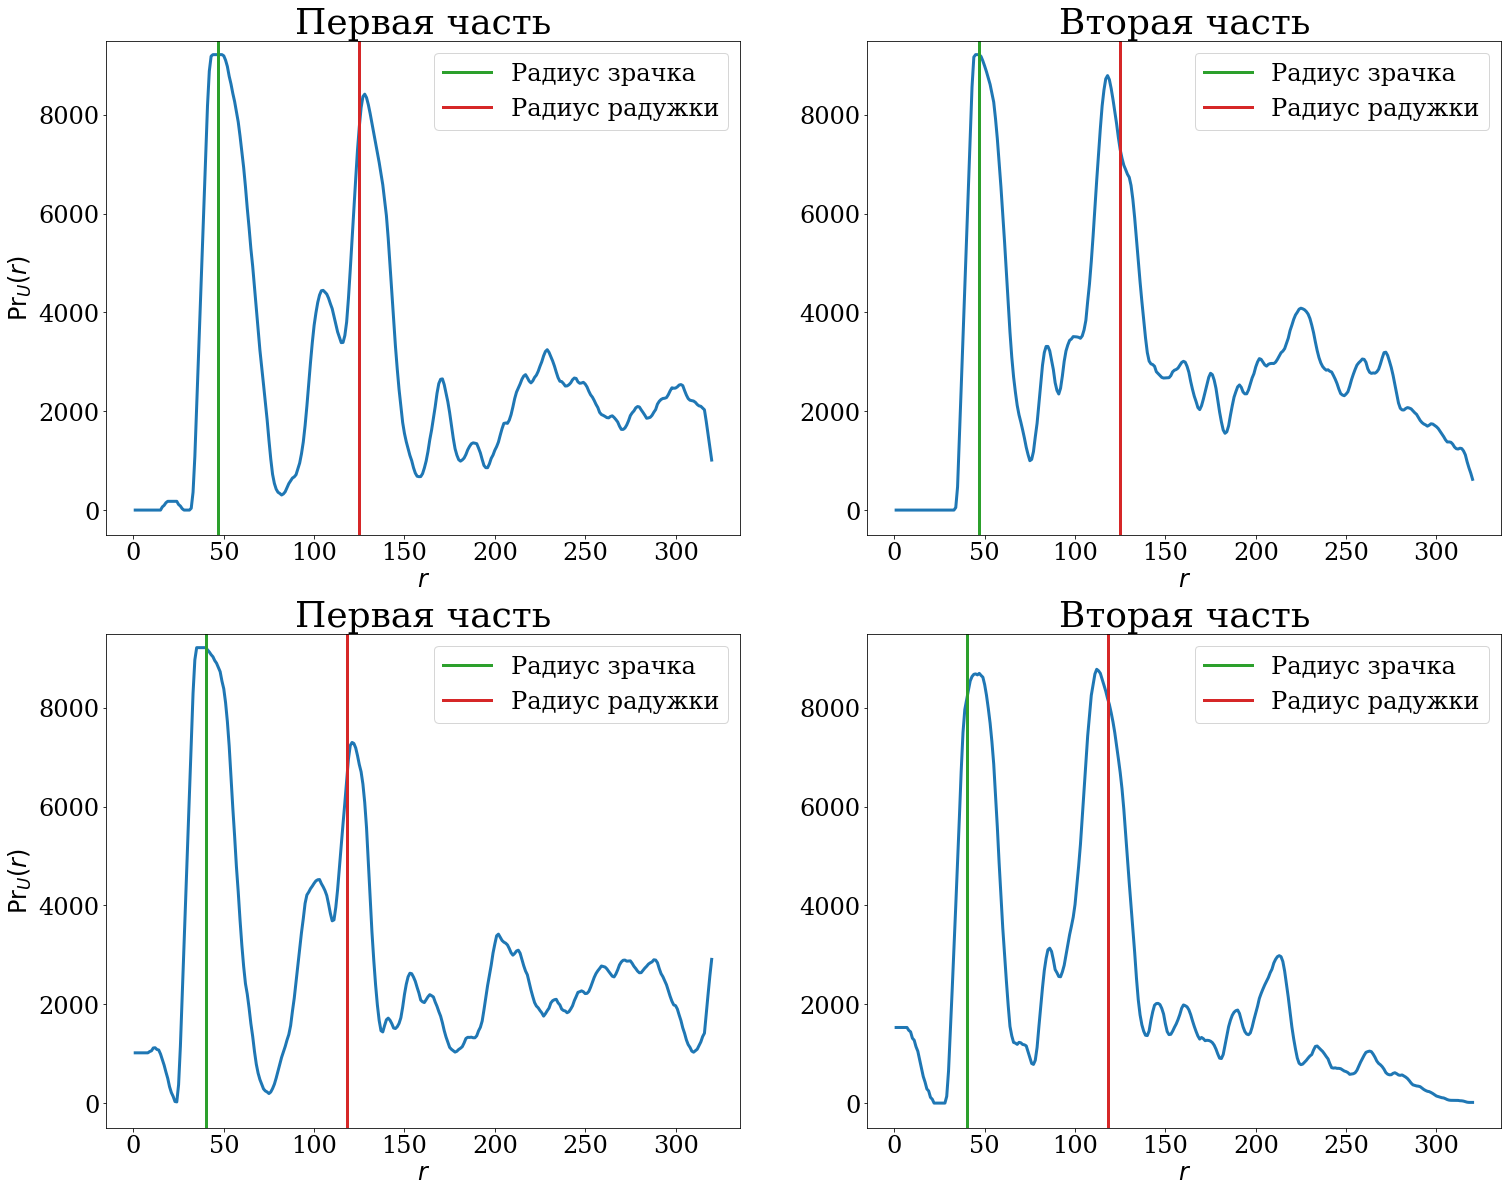

In [6]:
plt.figure(figsize=(25, 20))
for i in range(2):
    plt.subplot(2, 2, 2 * i + 1)
    plt.plot(data.loc[data.index[i], np.arange(1, 321)])
    plt.axvline(data.loc[data.index[i], 'PupR'], color='C2', label='Радиус зрачка')
    plt.axvline(data.loc[data.index[i], 'IriR'], color='C3', label='Радиус радужки')
    plt.title('Первая часть')
    plt.xlabel('$r$')
    plt.ylabel('$\\mathsf{Pr}_U(r)$')
    #plt.ylabel(f'Изображение {i+1}')
    plt.legend()
    plt.ylim((-500, 9500))
    
    plt.subplot(2, 2, 2 * i + 2)
    plt.plot(np.arange(1, 321), data.loc[data.index[i], np.arange(321, 641)])
    plt.axvline(data.loc[data.index[i], 'PupR'], color='C2', label='Радиус зрачка')
    plt.axvline(data.loc[data.index[i], 'IriR'], color='C3', label='Радиус радужки')
    plt.title('Вторая часть')
    plt.xlabel('$r$')
    plt.legend()
    plt.ylim((-500, 9500))

## 2. Вычислительный эксперимент

В данной части происходит обучение нейронной сети и ее выяснение ее возможностей.

In [75]:
sample = data[np.arange(1, 641)].to_numpy() / 9500
target = data[['PupR', 'IriR']].to_numpy()

In [76]:
train_sample, test_sample, train_target, test_target = train_test_split(
    sample, target, test_size=0.2, random_state=42
)

In [100]:
class FirstNet(nn.Module):
    '''Нейронная сеть с применением сверточных слоев
    '''
    def __init__(self):
        super(FirstNet, self).__init__()
        
        self.conv1 = nn.Conv1d(1, 10, 5, 2, 2)
        self.norm2 = nn.BatchNorm1d(10)
        self.relu2 = nn.ReLU()
        self.conv2 = nn.Conv1d(10, 5, 5, 2, 2)
        self.norm3 = nn.BatchNorm1d(5)
        self.relu3 = nn.ReLU()
        self.flat = nn.Flatten()
        self.linear3 = nn.Linear(800, 100)
        self.norm4 = nn.BatchNorm1d(100)
        self.relu4 = nn.ReLU()
        self.linear4 = nn.Linear(100, 2)
        
    def forward(self, x):
        x = self.relu2(self.norm2(self.conv1(x)))
        x = self.relu3(self.norm3(self.conv2(x)))
        x = self.linear3(self.flat(x))
        x = self.linear4(self.relu4(self.norm4(x)))
        
        return x

In [121]:
def batch_generator(X, y, batchsize, shuffle=True):
    '''
        Генерирует tuple из батча объектов и их меток
        X: np.ndarray -- выборка
        y: np.ndarray -- таргет
        batchsize: int -- размер батча
        device: str -- утсройство, на котором будут производиться вычисления
        shuffle: bool -- перемешивать выборку или нет
    '''

    indices = np.arange(len(X))

    # Во время обучения перемешиваем, во время тестирования - нет
    if shuffle:
        indices = np.random.permutation(indices)

    # Идем по всем данным с шагом batchsize.
    # Возвращаем start: start + batchsize объектов на каждой итерации
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]

        # Переведем массивы в соотв. тензоры. 
        # Для удобства переместим выборку на наше устройство (GPU).
        yield torch.FloatTensor(X[ix]), torch.FloatTensor(y[ix])

In [126]:
def train(model, criterion, optimizer,
          X_train, y_train, X_val, y_val,
          batch_size=64, num_epochs=100):
    '''Обучает нейронную сеть
    '''
    num_train_batches = len(X_train) // batch_size
    num_val_batches = len(X_val) // batch_size

    history = defaultdict(lambda: defaultdict(list))

    best_val_acc = 0.

    for epoch in range(num_epochs):
        train_loss = 0
        val_loss = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)  

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in batch_generator(X_train, y_train, batch_size):
                
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            logits = model.forward(X_batch)
            loss = criterion.forward(logits, y_batch)
            # Обратный проход, шаг оптимизатора и зануление градиентов
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # Используйте методы тензоров:
            # detach -- для отключения подсчета градиентов
            # cpu -- для перехода на cpu
            # numpy -- чтобы получить numpy массив

            train_loss += loss.detach().cpu().numpy()

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= num_train_batches
        history['loss']['train'].append(train_loss)
    
        # Устанавливаем поведение dropout / batch_norm  в тестирование
        model.eval()
        
        # Полный проход по валидации
        with torch.no_grad(): # Отключаем подсчет градиентов, то есть detach не нужен
            for X_batch, y_batch in batch_generator(X_val, y_val, batch_size):
                logits = model.forward(X_batch)
                loss = criterion.forward(logits, y_batch)
                
                val_loss += loss.cpu().numpy()

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= num_val_batches
        history['loss']['val'].append(val_loss)

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
    return history

In [105]:
train_sample_torch = torch.reshape(
    torch.tensor(train_sample, dtype=torch.float32),
    (train_sample.shape[0], 1, train_sample.shape[1])
)
test_sample_torch = torch.reshape(
    torch.tensor(test_sample, dtype=torch.float32),
    (test_sample.shape[0], 1, test_sample.shape[1])
)
train_target_torch = torch.tensor(train_target, dtype=torch.float32)
test_target_torch = torch.tensor(test_target, dtype=torch.float32)

In [123]:
net = FirstNet()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [127]:
history = train(
    net, criterion, optimizer,
    train_sample_torch, train_target_torch,
    test_sample_torch, test_target_torch,
    batch_size=64, num_epochs=100    
)

Epoch 1 of 100 took 0.215s
  training loss (in-iteration): 	1419.270394
  validation loss (in-iteration): 	41562.871094
Epoch 2 of 100 took 0.090s
  training loss (in-iteration): 	943.585072
  validation loss (in-iteration): 	69346.289062
Epoch 3 of 100 took 0.052s
  training loss (in-iteration): 	438.773042
  validation loss (in-iteration): 	2654.875000
Epoch 4 of 100 took 0.051s
  training loss (in-iteration): 	218.870517
  validation loss (in-iteration): 	2140.291870
Epoch 5 of 100 took 0.067s
  training loss (in-iteration): 	82.335813
  validation loss (in-iteration): 	541.300232
Epoch 6 of 100 took 0.058s
  training loss (in-iteration): 	91.103124
  validation loss (in-iteration): 	52.755693
Epoch 7 of 100 took 0.056s
  training loss (in-iteration): 	131.001120
  validation loss (in-iteration): 	251.504784
Epoch 8 of 100 took 0.053s
  training loss (in-iteration): 	51.231303
  validation loss (in-iteration): 	61.659073
Epoch 9 of 100 took 0.059s
  training loss (in-iteration): 	67

Epoch 75 of 100 took 0.094s
  training loss (in-iteration): 	4.787832
  validation loss (in-iteration): 	3.113168
Epoch 76 of 100 took 0.094s
  training loss (in-iteration): 	4.858290
  validation loss (in-iteration): 	4.093611
Epoch 77 of 100 took 0.064s
  training loss (in-iteration): 	4.324381
  validation loss (in-iteration): 	3.083164
Epoch 78 of 100 took 0.058s
  training loss (in-iteration): 	3.003536
  validation loss (in-iteration): 	3.388646
Epoch 79 of 100 took 0.057s
  training loss (in-iteration): 	3.436234
  validation loss (in-iteration): 	3.003266
Epoch 80 of 100 took 0.060s
  training loss (in-iteration): 	2.500015
  validation loss (in-iteration): 	2.942275
Epoch 81 of 100 took 0.048s
  training loss (in-iteration): 	3.544446
  validation loss (in-iteration): 	3.711761
Epoch 82 of 100 took 0.053s
  training loss (in-iteration): 	4.063070
  validation loss (in-iteration): 	2.846567
Epoch 83 of 100 took 0.056s
  training loss (in-iteration): 	3.299410
  validation loss 

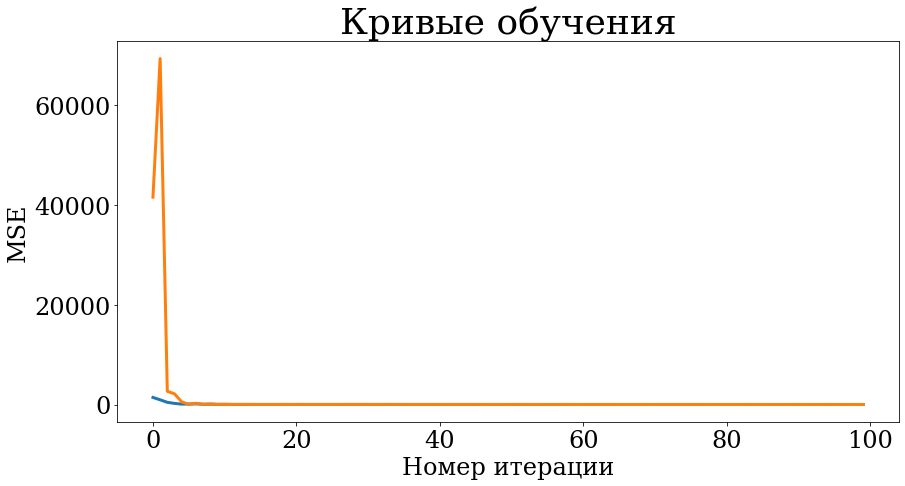

In [132]:
plt.figure(figsize=(14, 7))
plt.plot(history['loss']['train'], label='train')
plt.plot(history['loss']['val'], label='val')
plt.title('Кривые обучения')
plt.xlabel('Номер итерации')
plt.ylabel('MSE');